In [1]:

import numpy as np
import pandas as pd

In [2]:
train_X = pd.read_csv("Train_X.csv")
train_X.head(10)

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Profession_Encoded
0,1303834,23,3,3,13,43
1,7574516,40,10,9,13,11
2,3991815,66,4,4,10,17
3,6256451,41,2,2,12,11
4,5768871,47,11,3,14,18
5,6915937,64,0,0,12,18
6,3954973,58,14,8,12,28
7,1706172,33,2,2,14,16
8,7566849,24,17,11,11,1
9,8964846,23,12,5,13,27


In [3]:
train_Y = pd.read_csv("Train_Y.csv")
train_Y.head(10)

,Risk_Flag
0,0
1,0
2,0
3,1
4,1
5,0
6,0
7,0
8,0
9,0


## Making a node

In [4]:
class Node():
    def __init__(self,feature_index = None, threshold=None , left = None , right = None,info_gain = None , value=None):
    
        # for making decision
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node 
        self.value = value

## Tree class

In [5]:
import numpy as np

class DecisionTreeClassifier():
    def __init__(self, min_samples_split=3, max_depth=3):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, features_to_use, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, features_to_use)
            
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], features_to_use, curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], features_to_use, curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, features_to_use):
        ''' function to find the best split '''
            
        best_split ={}
        max_info_gain = -float("inf")
        best_split["info_gain"] = max_info_gain
        
        for feature_index in features_to_use:
            
            # Extract feature values from the dataset
            feature_values = dataset[:, feature_index]
            # Calculate the number of unique feature values
            num_unique_values = len(np.unique(feature_values))
            # If number of unique feature values is more than 100, choose 100 randomly, else choose all
            if num_unique_values > 100:
                # Randomly select 100 unique feature values from the dataset
                possible_thresholds = np.unique(np.random.choice(feature_values, size=100, replace=False))
            else:
                # Use all unique feature values
                possible_thresholds = np.unique(feature_values)
            
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y, features_to_use):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset, features_to_use)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None:
            return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)


In [27]:
import random
def bootstrap_feature(num_of_feature):
    # Generate 3 non-repetitive random numbers from 0 to 5
    random_numbers = random.sample(range(train_X.shape[1]), min(10, int(train_X.shape[1]*0.6) ))
    return random_numbers


In [28]:
def bootstrap_sample(x, y, num_samples):
    # Ensure x and y have the same number of samples
    assert len(x) == len(y), "x and y must have the same number of samples"

    # Get the number of samples in x
    num_samples_total = len(x)

    # Generate random indices for the bootstrap sample
    indices = np.random.choice(num_samples_total, size=num_samples, replace=True)

    # Use the indices to select samples from x and y
    x_new = x.iloc[indices]  # Use iloc for DataFrame indexing
    y_new = y.iloc[indices]  # Use iloc for DataFrame indexing

    return x_new, y_new

In [29]:
def balance_data2(x_file, y_file):
    # Read the data from the files
    X = pd.read_csv(x_file)
    y = pd.read_csv(y_file)

    # Get indices for each class
    indices_0 = y[y['Risk_Flag'] == 0].index
    indices_1 = y[y['Risk_Flag'] == 1].index

    # Sample the indices for each class
    min_samples = min(len(indices_0), len(indices_1))
    sampled_indices = np.concatenate([
        np.random.choice(indices_0, min_samples, replace=False),
        np.random.choice(indices_1, min_samples, replace=False)
    ])

    # Get the corresponding X and y values
    X_balanced = X.loc[sampled_indices]
    y_balanced = y.loc[sampled_indices]

    # Reset index
    X_balanced.reset_index(drop=True, inplace=True)
    y_balanced.reset_index(drop=True, inplace=True)


    return X_balanced, y_balanced


In [30]:
X_train,Y_train = balance_data2("Train_X.csv","Train_Y.csv")

In [31]:
X_train

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Profession_Encoded
0,7327980,43,4,4,13,10
1,6197730,71,3,3,13,19
2,4981446,77,10,10,11,49
3,7225783,63,9,9,12,19
4,1434051,67,18,10,13,49
...,...,...,...,...,...,...
61987,7903196,76,1,1,13,41
61988,5087803,28,15,12,14,33
61989,3593774,57,11,11,11,17
61990,3507164,25,11,7,14,11


In [32]:
for column in X_train.columns:
    value_counts = X_train[column].value_counts()
    print(f"Value counts for column '{column}':")
    print(value_counts)
    print()

Value counts for column 'Income':
3154685    35
5965932    35
8143086    34
3424035    34
700444     34
           ..
8560086     1
752140      1
5674526     1
8741225     1
3507164     1
Name: Income, Length: 17220, dtype: int64

Value counts for column 'Age':
33    1342
27    1335
66    1334
22    1326
76    1216
26    1215
48    1208
54    1207
55    1170
45    1160
41    1158
21    1154
47    1154
25    1148
24    1144
72    1124
78    1117
79    1117
59    1113
60    1100
50    1094
35    1093
30    1091
23    1090
69    1088
57    1078
31    1075
28    1062
61    1061
29    1039
68    1035
42    1033
53    1033
56    1029
71    1029
70    1020
63    1012
58     999
37     992
65     991
38     989
49     978
32     971
62     970
43     961
46     952
40     943
77     942
64     916
74     915
67     904
36     894
39     891
75     883
34     880
73     851
51     817
44     791
52     758
Name: Age, dtype: int64

Value counts for column 'Experience':
15    3223
1     3195
6   

Correlation Matrix:


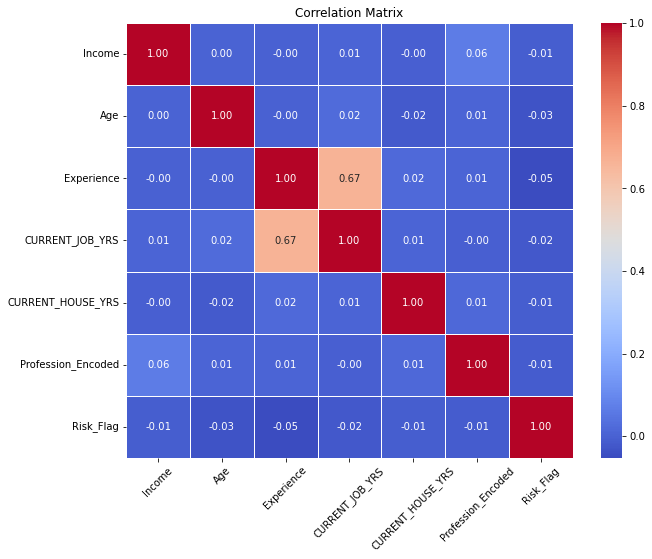

In [33]:
df = pd.concat([X_train, Y_train], axis=1)

# Calculate correlation matrix
correlation_matrix = df.corr()

print("Correlation Matrix:")
#print(correlation_matrix)
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming correlation_matrix is the correlation matrix calculated earlier

# Plot correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [34]:
Y_train

,Risk_Flag
0,0
1,0
2,0
3,0
4,0
...,...
61987,1
61988,1
61989,1
61990,1


In [35]:
# Assuming Y_test is your numpy array
unique_values, value_counts = np.unique(Y_train, return_counts=True)
value_counts_dict = dict(zip(unique_values, value_counts))
print("Value counts in Y_train:", value_counts_dict)

Value counts in Y_train: {0: 30996, 1: 30996}


## testing data

In [36]:
def balance_data1(x_test_file, y_test_file):
    # Read the test data from files
    x_test = pd.read_csv(x_test_file)
    y_test = pd.read_csv(y_test_file)
    
    # Find the indices of 0s and 1s in y_test
    indices_0 = np.where(y_test == 0)[0]
    indices_1 = np.where(y_test == 1)[0]
    
    # Sample an equal number of instances for each class
    min_samples = min(len(indices_0), len(indices_1))
    sampled_indices_0 = np.random.choice(indices_0, min_samples, replace=False)
    sampled_indices_1 = np.random.choice(indices_1, min_samples, replace=False)
    
    # Concatenate the sampled indices
    sampled_indices = np.concatenate([sampled_indices_0, sampled_indices_1])
    
    # Get corresponding x_test and y_test values
    balanced_x_test = x_test.iloc[sampled_indices]
    balanced_y_test = y_test.iloc[sampled_indices]
    
    # Convert to numpy arrays
    balanced_x_test = balanced_x_test.to_numpy()
    balanced_y_test = balanced_y_test.to_numpy().flatten()  # Flatten to 1D array
    
    return balanced_x_test, balanced_y_test


In [74]:
X_test,Y_test = balance_data1('test_X1.csv','test_Y1.csv')

In [77]:
X_test

array([[3356017,      52,       0,       0,      14,      18],
       [9083499,      77,      19,      13,      10,      49],
       [4209616,      55,       8,       6,      11,      44],
       ...,
       [4279587,      56,      11,      11,      10,      44],
       [1484805,      46,      13,       8,      14,      40],
       [1966474,      26,      16,       4,      10,      22]],
      dtype=int64)

In [78]:
Y_test

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [79]:
#X_test,Y_test =  bootstrap_sample(X_train,Y_train,10000)

In [80]:
#X_test

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Profession_Encoded
5422,1006955,31,20,3,13,9
21036,66912,27,10,10,14,11
21227,2363748,36,13,7,10,46
21585,4470476,38,0,0,13,13
50906,2979441,44,7,7,12,34
...,...,...,...,...,...,...
52936,3286046,25,9,8,11,17
48947,3602416,48,3,3,13,20
6309,1886371,68,15,7,10,41
5006,549784,63,4,4,13,34


In [81]:
#X_test = X_test.values

In [83]:

#Y_test = Y_test.values

In [84]:
#print(X_test)
#print(Y_test)

[[1006955      31      20       3      13       9]
 [  66912      27      10      10      14      11]
 [2363748      36      13       7      10      46]
 ...
 [1886371      68      15       7      10      41]
 [ 549784      63       4       4      13      34]
 [6134981      49       2       2      10      25]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [1]]


In [85]:

# Assuming Y_test is your numpy array
unique_values, value_counts = np.unique(Y_test, return_counts=True)
value_counts_dict = dict(zip(unique_values, value_counts))
print("Value counts in Y_test:", value_counts_dict)

Value counts in Y_test: {0: 5004, 1: 4996}


In [ ]:
tree = int(input("enter number of tress :- "))
Y_pred = np.zeros(X_test.shape[0]) 

for i in range(tree):

    X_train1 , Y_train1 = bootstrap_sample(X_train,Y_train,10000)
    features_to_use = bootstrap_feature(X_train.shape[0])
    classifier = DecisionTreeClassifier(min_samples_split=50, max_depth=3)
    classifier.fit(X_train1,Y_train1,features_to_use)

    print("tree ",i ," :- \n")
    #classifier.print_tree()
    #print("\n\n")
    
    Y_pred_iteration = np.array(classifier.predict(X_test))
    Y_pred = np.sum([Y_pred, Y_pred_iteration], axis=0) if i > 0 else Y_pred_iteration



enter number of tress :- 20
tree  0  :- 



In [87]:
Y_predicted = np.where(Y_pred >= float(float(tree)/2.0), 1, 0)

In [88]:
unique_values, value_counts = np.unique(Y_predicted, return_counts=True)
value_counts_dict = dict(zip(unique_values, value_counts))
print("Value counts in Y_predicted:", value_counts_dict)

Value counts in Y_predicted: {0: 4862, 1: 5138}


In [89]:
Y_pred 

array([6, 7, 5, ..., 5, 4, 9], dtype=int64)

In [90]:

from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_predicted)*100

55.92

In [91]:
cnt0 = 0
cnt1 = 0
for i in range(len(Y_test)):
    if Y_test[i] != Y_predicted[i]:
        print("answer = ",Y_test[i]," and Y_pred = ",Y_pred[i] , Y_predicted[i])
        if Y_test[i] == 0:
            cnt0 += 1
        else:
            cnt1 += 1
        
print("when original is 0 = ",cnt0," and when original is 1 = ",cnt1)
        

answer =  [0]  and Y_pred =  6 1
answer =  [0]  and Y_pred =  7 1
answer =  [0]  and Y_pred =  5 1
answer =  [0]  and Y_pred =  5 1
answer =  [1]  and Y_pred =  3 0
answer =  [1]  and Y_pred =  3 0
answer =  [1]  and Y_pred =  4 0
answer =  [0]  and Y_pred =  8 1
answer =  [0]  and Y_pred =  5 1
answer =  [0]  and Y_pred =  7 1
answer =  [0]  and Y_pred =  5 1
answer =  [0]  and Y_pred =  6 1
answer =  [0]  and Y_pred =  5 1
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  2 0
answer =  [1]  and Y_pred =  3 0
answer =  [0]  and Y_pred =  6 1
answer =  [1]  and Y_pred =  4 0
answer =  [0]  and Y_pred =  5 1
answer =  [1]  and Y_pred =  4 0
answer =  [0]  and Y_pred =  5 1
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  2 0
answer =  [0]  and Y_pred =  6 1
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  2 0
answer =  [1]  and Y_pred =  4 0
answer =  [0]  and Y_pred =  8 1
answer =  [0]  and Y_pred =  6 1
answer =  

answer =  [0]  and Y_pred =  9 1
answer =  [0]  and Y_pred =  5 1
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  3 0
answer =  [1]  and Y_pred =  4 0
answer =  [0]  and Y_pred =  5 1
answer =  [0]  and Y_pred =  5 1
answer =  [1]  and Y_pred =  3 0
answer =  [1]  and Y_pred =  4 0
answer =  [0]  and Y_pred =  7 1
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  2 0
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  3 0
answer =  [1]  and Y_pred =  3 0
answer =  [0]  and Y_pred =  9 1
answer =  [1]  and Y_pred =  2 0
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  0 0
answer =  [1]  and Y_pred =  2 0
answer =  [0]  and Y_pred =  7 1
answer =  [1]  and Y_pred =  2 0
answer =  [1]  and Y_pred =  3 0
answer =  [0]  and Y_pred =  7 1
answer =  [0]  and Y_pred =  6 1
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  3 0
answer =  [1]  and Y_pred =  2 0
answer =  [0]  and Y_pred =  8 1
answer =  [1]  and Y_pred =  4 0
answer =  

answer =  [0]  and Y_pred =  5 1
answer =  [1]  and Y_pred =  3 0
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  2 0
answer =  [0]  and Y_pred =  6 1
answer =  [0]  and Y_pred =  6 1
answer =  [1]  and Y_pred =  3 0
answer =  [1]  and Y_pred =  4 0
answer =  [0]  and Y_pred =  6 1
answer =  [1]  and Y_pred =  3 0
answer =  [1]  and Y_pred =  4 0
answer =  [0]  and Y_pred =  9 1
answer =  [1]  and Y_pred =  3 0
answer =  [0]  and Y_pred =  9 1
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  3 0
answer =  [0]  and Y_pred =  5 1
answer =  [0]  and Y_pred =  7 1
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  3 0
answer =  [0]  and Y_pred =  7 1
answer =  [1]  and Y_pred =  4 0
answer =  [0]  and Y_pred =  5 1
answer =  [0]  and Y_pred =  5 1
answer =  [0]  and Y_pred =  6 1
answer =  [1]  and Y_pred =  3 0
answer =  [0]  and Y_pred =  7 1
answer =  [1]  and Y_pred =  3 0
answer =  

answer =  [1]  and Y_pred =  3 0
answer =  [0]  and Y_pred =  5 1
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  2 0
answer =  [1]  and Y_pred =  4 0
answer =  [0]  and Y_pred =  5 1
answer =  [0]  and Y_pred =  5 1
answer =  [1]  and Y_pred =  3 0
answer =  [1]  and Y_pred =  4 0
answer =  [0]  and Y_pred =  7 1
answer =  [0]  and Y_pred =  6 1
answer =  [0]  and Y_pred =  6 1
answer =  [1]  and Y_pred =  3 0
answer =  [0]  and Y_pred =  6 1
answer =  [1]  and Y_pred =  3 0
answer =  [0]  and Y_pred =  5 1
answer =  [0]  and Y_pred =  6 1
answer =  [0]  and Y_pred =  8 1
answer =  [0]  and Y_pred =  5 1
answer =  [1]  and Y_pred =  3 0
answer =  [0]  and Y_pred =  5 1
answer =  [1]  and Y_pred =  2 0
answer =  [1]  and Y_pred =  4 0
answer =  [0]  and Y_pred =  7 1
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  1 0
answer =  [0]  and Y_pred =  6 1
answer =  [0]  and Y_pred =  5 1
answer =  [0]  and Y_pred =  5 1
answer =  [1]  and Y_pred =  3 0
answer =  

answer =  [0]  and Y_pred =  5 1
answer =  [1]  and Y_pred =  3 0
answer =  [0]  and Y_pred =  10 1
answer =  [0]  and Y_pred =  6 1
answer =  [0]  and Y_pred =  8 1
answer =  [0]  and Y_pred =  9 1
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  3 0
answer =  [0]  and Y_pred =  5 1
answer =  [0]  and Y_pred =  7 1
answer =  [0]  and Y_pred =  5 1
answer =  [1]  and Y_pred =  3 0
answer =  [1]  and Y_pred =  2 0
answer =  [1]  and Y_pred =  3 0
answer =  [1]  and Y_pred =  3 0
answer =  [1]  and Y_pred =  4 0
answer =  [0]  and Y_pred =  5 1
answer =  [0]  and Y_pred =  6 1
answer =  [0]  and Y_pred =  5 1
answer =  [1]  and Y_pred =  2 0
answer =  [1]  and Y_pred =  3 0
answer =  [0]  and Y_pred =  6 1
answer =  [0]  and Y_pred =  5 1
answer =  [1]  and Y_pred =  4 0
answer =  [0]  and Y_pred =  7 1
answer =  [1]  and Y_pred =  2 0
answer =  [1]  and Y_pred =  3 0
answer =  [1]  and Y_pred =  3 0
answer =  [0]  and Y_pred =  9 1
answer =  [0]  and Y_pred =  9 1
answer = 

answer =  [0]  and Y_pred =  6 1
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  3 0
answer =  [1]  and Y_pred =  4 0
answer =  [0]  and Y_pred =  5 1
answer =  [1]  and Y_pred =  3 0
answer =  [0]  and Y_pred =  6 1
answer =  [1]  and Y_pred =  2 0
answer =  [0]  and Y_pred =  5 1
answer =  [0]  and Y_pred =  7 1
answer =  [0]  and Y_pred =  5 1
answer =  [0]  and Y_pred =  8 1
answer =  [0]  and Y_pred =  5 1
answer =  [0]  and Y_pred =  6 1
answer =  [1]  and Y_pred =  2 0
answer =  [1]  and Y_pred =  4 0
answer =  [0]  and Y_pred =  7 1
answer =  [1]  and Y_pred =  1 0
answer =  [1]  and Y_pred =  2 0
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  4 0
answer =  [0]  and Y_pred =  8 1
answer =  [1]  and Y_pred =  2 0
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  2 0
answer =  [0]  and Y_pred =  8 1
answer =  [1]  and Y_pred =  4 0
answer =  [0]  and Y_pred =  5 1
answer =  [0]  and Y_pred =  7 1
answer =  [1]  and Y_pred =  4 0
answer =  

answer =  [1]  and Y_pred =  2 0
answer =  [1]  and Y_pred =  3 0
answer =  [0]  and Y_pred =  7 1
answer =  [0]  and Y_pred =  8 1
answer =  [0]  and Y_pred =  6 1
answer =  [0]  and Y_pred =  6 1
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  2 0
answer =  [0]  and Y_pred =  6 1
answer =  [1]  and Y_pred =  3 0
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  1 0
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  3 0
answer =  [1]  and Y_pred =  2 0
answer =  [0]  and Y_pred =  8 1
answer =  [0]  and Y_pred =  5 1
answer =  [1]  and Y_pred =  4 0
answer =  [0]  and Y_pred =  8 1
answer =  [1]  and Y_pred =  2 0
answer =  [0]  and Y_pred =  5 1
answer =  [0]  and Y_pred =  5 1
answer =  [1]  and Y_pred =  3 0
answer =  [0]  and Y_pred =  6 1
answer =  [1]  and Y_pred =  3 0
answer =  [1]  and Y_pred =  3 0
answer =  [0]  and Y_pred =  5 1
answer =  [1]  and Y_pred =  3 0
answer =  [0]  and Y_pred =  6 1
answer =  [0]  and Y_pred =  7 1
answer =  

answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  2 0
answer =  [0]  and Y_pred =  9 1
answer =  [0]  and Y_pred =  7 1
answer =  [0]  and Y_pred =  6 1
answer =  [0]  and Y_pred =  5 1
answer =  [1]  and Y_pred =  3 0
answer =  [1]  and Y_pred =  1 0
answer =  [0]  and Y_pred =  8 1
answer =  [1]  and Y_pred =  4 0
answer =  [0]  and Y_pred =  5 1
answer =  [1]  and Y_pred =  3 0
answer =  [1]  and Y_pred =  4 0
answer =  [0]  and Y_pred =  6 1
answer =  [1]  and Y_pred =  2 0
answer =  [0]  and Y_pred =  5 1
answer =  [1]  and Y_pred =  2 0
answer =  [1]  and Y_pred =  4 0
answer =  [1]  and Y_pred =  1 0
answer =  [0]  and Y_pred =  5 1
answer =  [1]  and Y_pred =  4 0
answer =  [0]  and Y_pred =  5 1
answer =  [0]  and Y_pred =  7 1
answer =  [1]  and Y_pred =  3 0
answer =  [1]  and Y_pred =  3 0
answer =  [0]  and Y_pred =  5 1
answer =  [0]  and Y_pred =  5 1
answer =  [0]  and Y_pred =  7 1
answer =  